# 다음에 볼 영화 예측하기

## 1. 기본 준비

- 주요 라이브러리 불러오기 및 버전 확인

In [365]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.5
2.8.0


In [366]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

- 경로 지정

In [367]:
path = '/content/drive/MyDrive/Aiffel/Exploration/E-16/'

In [368]:
data_path = '/content/drive/MyDrive/Aiffel/Exploration/E-16/data/'

In [369]:
train_path = data_path + 'ratings.dat'


## 2. 데이터 로드 및 전처리


### 2.1. 데이터 로드

Movielens 1M Dataset

- 개요
>- 미네소타 대학의 그룹렌즈(FroupLens)가 제공하는 공개 데이터셋
>- 영화에 대한 사용자의 별점(rating) 데이터
>- 다양한 크기의 데이터셋 중 여기서는 1M 크기를 사용

- 특성
>- 별점 데이터는 대표적인 명시적 데이터이다.
>- session base인 실습과 달리 UserID를 기반으로 하므로 Matrix Factorization을 사용할 수 있을 것 같다.
>- 주어진 데이터에서 개별 사용자에 대한 특성은 없다.

- rating, time, 두 데이터의 관게에 대한 고민이 필요해 보인다.
    > 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

- 참조
>- https://orill.tistory.com/entry/Explicit-vs-Implicit-Feedback-Datasets?category=1066301
>= https://abluesnake.tistory.com/98

- 데이터 로드를 위한 함수 지정

In [370]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

- 데이터 로드, 정렬

In [371]:
data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


## 2.2. 데이터 확인

- 결측치 확인

In [372]:
data.isnull().sum()

UserId    0
ItemId    0
Rating    0
Time      0
dtype: int64

- 유니크 데이터 개수 확인

In [373]:
data['UserId'].nunique(), data['ItemId'].nunique(), data['Rating'].nunique()

(6040, 3706, 5)

- 레이팅의 종류 확인. 0점은 없다.

In [374]:
data['Rating'].unique()

array([4, 5, 3, 2, 1], dtype=int32)

*실습의 세션ID와는 달리 userID는 실제 유저수와 거의 같을 것 같다. 유의미한 차이일지는 아직 모르겠지만 기억해두자.*

In [375]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [376]:
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

In [377]:
user_length.min(), user_length.max()

(20, 2314)

In [378]:
user_length.quantile(0.999)

1343.181000000005

- 중간값 96, 평균 약 165
- 99.9%의 length는 1343이하.
- max_length는 2314

In [379]:
# 2314로 가장 많은 갯수를 등록한 유저의 기록을 살펴보자
long_UL = user_length[user_length==2314].index[0]
data[data['UserId']==long_UL]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


거의 동일한 시간대에 대량으로 점수를 매겼다. 정상적으로 보이지는 않는다.

- user_length 길이 기준 하위 99.9% 까지의 분포 누적 합 확인

In [380]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

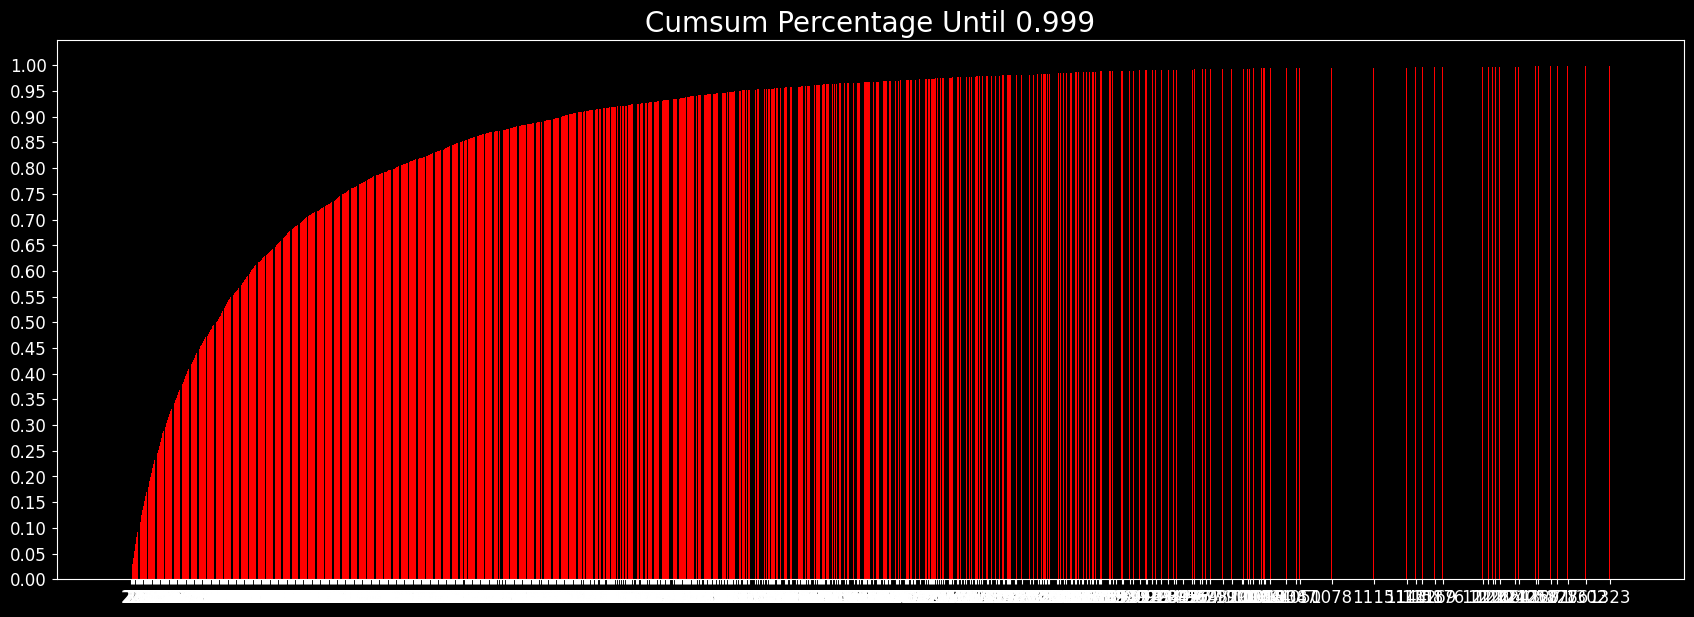

In [381]:
import matplotlib.pyplot as plt

plt.style.use(['dark_background'])

plt.figure(figsize=(21, 7))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

- 박스플롯으로 확인해보자

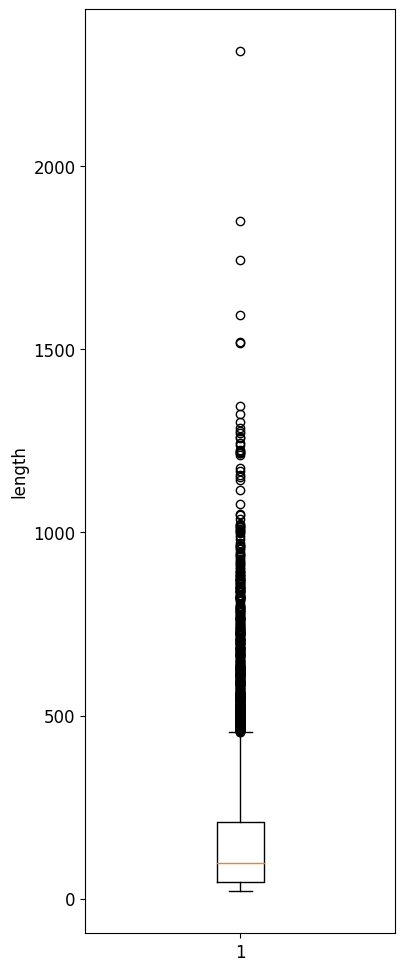

In [382]:

plt.style.use('default')
plt.rcParams['figure.figsize'] = (4, 12)
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots()

ax.boxplot(user_length)
ax.set_ylabel('length')

plt.show()

- 아웃라이어로 마킹되는 값이 많으나 분포가 조밀하다.
- 99.9%의 데이터가 속한 1343을 초과하는 데이터는 전처리 과정에서 일단 제거해도 무방할 것으로 보인다.
- 피규어 사이즈의 세로를 길게 해 더 직관적으로 확인해보았다.

In [383]:
length_percent_cumsum_999.index[-1]

1323

- 데이터의 시간단위 정보 확인

In [384]:
oldest, latest = data['Time'].min(), data['Time'].max()  

In [385]:
print(oldest)
print(latest)

956703932
1046454590


In [386]:
# 날짜, 시간 표기로 확인
print(dt.datetime.utcfromtimestamp(oldest).strftime('%Y-%m-%d %H:%M:%S'))  
print(dt.datetime.utcfromtimestamp(latest).strftime('%Y-%m-%d %H:%M:%S'))

2000-04-25 23:05:32
2003-02-28 17:49:50


>- 자료의 레코딩 기간이 3년에 조금 못미치는데, 3년간 매일 한 편의 영화를 보더라도 1095편이므로 
1323이라는 평가 수도 그리 타당해 보이지는 않는다.
>- 악의적인 조작이 아니라, 관련 전문가 등일 가능성도 있으나, 일반 사용자를 대상으로 영화를 추천하기 위해서는 조절이 필요해 보인다


In [387]:
length_percent_cumsum_99 = length_percent_cumsum[length_percent_cumsum < 0.99]
user_length.quantile(0.99)

906.659999999998

In [388]:
print(len(data[data['Time'] > latest - (86400*365*3)]))  # 3년치 데이터
print(len(data[data['Time'] > latest - (86400*365*2)]))  # 최신 2년치 데이터
print(len(data[data['Time'] > latest - (86400*365*1)]))  # 최신 1년치 데이터

1000209
69349
21704


- 레이팅의 분포를 확인

## 2.3. 전처리

### 2.3.1. 제거할 데이터

- 평가 개수가 정상 범주를 넘어가는 데이터 제거

In [391]:
drop_index = user_length[user_length>885].index

In [392]:
type(drop_index)

pandas.core.indexes.numeric.Int64Index

In [393]:
drop_index = drop_index.tolist()

In [ ]:
drop_index

In [395]:
data = data[~data.UserId.isin(drop_index)]

In [396]:
data['UserId'].nunique()

5973

In [397]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6035    280
6037    202
6038     20
6039    123
6040    341
Length: 5973, dtype: int64

- 부정적 평가를 제거



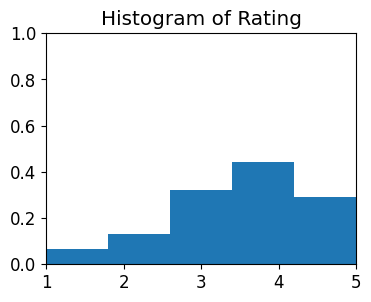

In [399]:
plt.rcParams['figure.figsize'] = (4, 3)
plt.hist(data['Rating'], density=True,bins=5)
plt.title('Histogram of Rating')
plt.axis([1, 5, 0, 1])
plt.show()

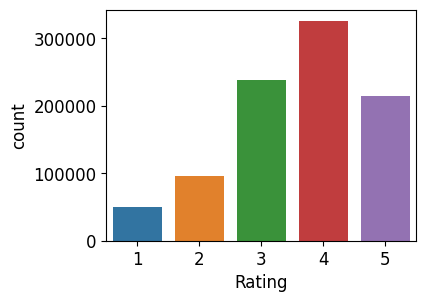

In [400]:
import seaborn as sns
sns.countplot(x="Rating", data=data)
plt.show()

- 분포를 근거로 바로 적용한다면 2 이하의 점수를 부정적인 평가로 판단하여 대상에서 제외할 수 있을 것이다.
- 하지만 모든 개별 유저가 점수에 대한 기준이 동일하지 않을 수 있다.
- 유저 각각에 대한 레이팅 평균을 확인하는 것이 유의미 할 수 있을 것 같다.

- 개별 userId별 레이팅 평균

In [440]:
user = []
mean = []
for i in range(6040):
    i = i + 1
    
    df = (data[data.UserId.isin([i])]) 
    if df['Rating'].sum() != 0:
        user.append(str(i))
        mean.append(df['Rating'].mean())

In [441]:
len(user)

5973

In [450]:
type(mean[0])

float

In [456]:
# 평균 점수의 평균
np.mean(mean)

3.707408598946025

In [444]:
rating_mean = dict(zip(user, mean))

In [447]:
rating_mean['1']

4.188679245283019

## 일단 제출합니다

- 컨디션 난조(..)와 데이터프레임 다루기 미숙으로
너무 지체되었습니다. 여전히 모니터 조금 오래 보면 한 쪽 눈이 너무 안보여서 힘들어요 ㅠㅠ

- 원했던 기준은 두 가지였습니다.
>- 유저별 평균 점수의 반올림 값 미만 레이팅 제거
>- 남은 데이터 중, 시간 순서로 가장 최신 20% 자료에 대해 더 높은 가중치 부여.
>- 가능하다면 추후에 진행하겠습니다.